In [1]:
!pip install neo4j
!pip install python-igraph
!pip install easygui
!pip install cairocffi

     |████████████████████████████████| 90 kB 3.2 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.3-py3-none-any.whl size=116069 sha256=98cdb3ce623dd11ec25e6a29e3e09c36c94df350f829ac835416ea782158fd5d
  Stored in directory: /root/.cache/pip/wheels/db/dd/76/acacd519878f133f2f869aec70db548d89e04013209c3c62bc
Successfully built neo4j
     |████████████████████████████████| 3.1 MB 4.9 MB/s 
     |████████████████████████████████| 92 kB 362 kB/s 
     |████████████████████████████████| 88 kB 3.8 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=63c96edbd12a5666a546c2a443990b93304e4a252ebadf02fb7472fccf7c8dd5
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [1]:
from neo4j import GraphDatabase
import igraph as ig
from skimage.io import imread
import glob
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import warnings
import random
import numpy as np
#warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [109]:
z = ig.Graph.Read_GraphML("/content/drive/My Drive/ALSSN/zurich.graphml")

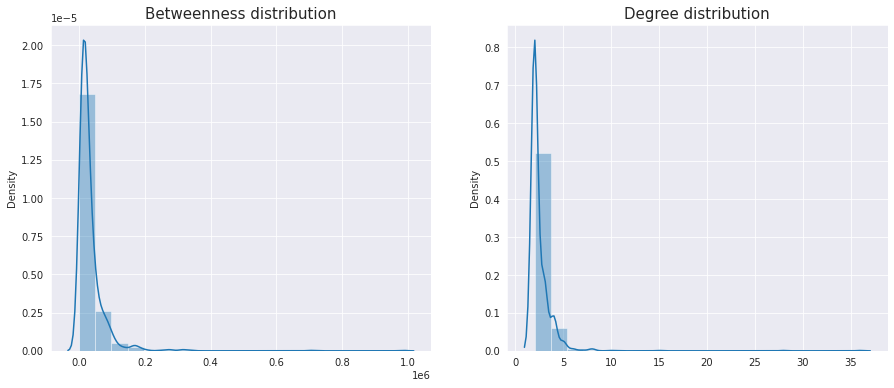

In [5]:
btw = z.betweenness()
deg = z.degree()
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.distplot(btw, bins=20)
plt.title('Betweenness distribution', fontsize=15)
plt.subplot(122)
sns.distplot(deg, bins=20)
plt.title('Degree distribution', fontsize=15);

In [6]:
z.vcount(), z.is_directed()

(1346, True)

In [98]:
def generate_graph(graph, modules, iteration=None, delete_previous_plots=True, layout='auto'):
  
  if delete_previous_plots and iteration==1:
    for c in glob.glob('cluster*png'):
      os.remove(c)

  layout_gr = graph.layout(layout)

  colors =np.random.permutation(sns.color_palette("hls", len(modules))).tolist()
  #colors = sns.color_palette("hls", k)
  graph.vs['color'] = [None]
  for clid, cluster in enumerate(modules):
      for member in cluster:
          graph.vs[member]['color'] = colors[clid]

  visual_style = {}
  visual_style["vertex_size"] = 5
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  if iteration:
    pl.save('clusters_{}_iter{}.png'.format(len(modules), iteration))
  else:
    pl.save('clusters_{}.png'.format(len(modules)))
  #return pl

def plot_graphs(img_path=os.getcwd(), plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'cluster*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][4:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//2
    cols = len(img_list)//4 + 1
  else:
    rows = len(img_list)//2
    cols = len(img_list)//4

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'iteration ' + imf.split('_')[-1][4:-4] + '\n' +'n_clusters: ' + imf.split('_')[1] 
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

1) Select central nodes to be removed from the network in subgraphs

In [ ]:
import numpy as np
# iterate over all created subgraphs created:
subg_cent_vert = []
clusters = z.clusters()
for c in clusters:  # decomposition of graphs onto subgraphs NEEDED??
    subgraph = z.subgraph(c)
    cent = subgraph.eigenvector_centrality(directed=True)
    # get index of access the most central node
    subg_cent_vert.append(z.vs[c][subgraph.vs[np.argmax(cent)].index].index)

2) Analysis carried out in a subgraph. The largest subgraph is selected and, iteratively, the node with the highest centrality is removed from the subgraph, then the communities are computed with the Louvain algorithm. (other measures such as shortest path, betweenness, modularity, have to be added and stored in a df for the following analysis)

In [88]:
def get_most_central_node(subgraph, method='eig_cent'):
  if method=='btw':
    # Approach of most central node selection taken from excercise session 3
    #wdeg = subgraph.strength()
    betw = subgraph.betweenness()
    # Select node with the highest degree and betweenness
    #vid = subgraph.vs[np.where((wdeg==np.amax(wdeg)) & (betw==np.amax(betw)))[0][0]].index
    vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index
  elif method=='eig_cent':
    cent = subgraph.eigenvector_centrality()
    vid = subgraph.vs[np.argmax(cent)].index
  
  return vid


In [102]:
def process(graph_undirected, iterations=10, save_plots=True):
  metrics = pd.DataFrame(columns=['subgraph', 'modules', 'iteration', 'betweenness', 'shortest_path', 'modularity'])
  for i in range(iterations):
    if i==0:
      # in the first iteration we don't remove anything, we just compute the baseline measures
      subgraph = graph_undirected.clusters().giant()
      msg = 'number of nodes: {}, number of edges: {}'.format(subgraph.vcount(), subgraph.ecount())
    else:
      # get most central vertex
      v_id = get_most_central_node(subgraph, method='btw') 
      # remove from subgraph
      subgraph.delete_vertices(v_id)
      msg = 'removed node: {}, number of nodes: {}, number of edges: {}'.format(v_id, subgraph.vcount(), subgraph.ecount())
    lvn = subgraph.community_multilevel()
    row = pd.Series(data = {'subgraph': subgraph, 
                          'iteration': i, 
                          'modules': lvn,
                          'betweenness': subgraph.betweenness(),
                          #'shortest_paths':subgraph.get_shortest_paths(0, to=5, weights=subgraph.es["weight"], output="epath",), 
                          'modularity': lvn.modularity,
                          'n_clusters': len(lvn)})
    #communities = lvn.subgraphs()
    metrics = metrics.append(row, ignore_index=True)
    if save_plots:
      generate_graph(subgraph, lvn, iteration=i+1, layout='drl')
    
    print(msg)
  return metrics

In [103]:
# convert network to undirected in order to perform the Louvain algorithm
z_undirected = z.copy()
z_undirected.to_undirected()
metrics = process(z_undirected, iterations=50, save_plots=True)

number of nodes: 1346, number of edges: 1657
removed node: 765, number of nodes: 1345, number of edges: 1636
removed node: 586, number of nodes: 1344, number of edges: 1609
removed node: 1026, number of nodes: 1343, number of edges: 1596
removed node: 450, number of nodes: 1342, number of edges: 1589
removed node: 420, number of nodes: 1341, number of edges: 1583
removed node: 1124, number of nodes: 1340, number of edges: 1579
removed node: 248, number of nodes: 1339, number of edges: 1575
removed node: 320, number of nodes: 1338, number of edges: 1570
removed node: 42, number of nodes: 1337, number of edges: 1565
removed node: 346, number of nodes: 1336, number of edges: 1559
removed node: 542, number of nodes: 1335, number of edges: 1554
removed node: 330, number of nodes: 1334, number of edges: 1550
removed node: 221, number of nodes: 1333, number of edges: 1544
removed node: 155, number of nodes: 1332, number of edges: 1539
removed node: 742, number of nodes: 1331, number of edges:

### Graph topology changes across iterations

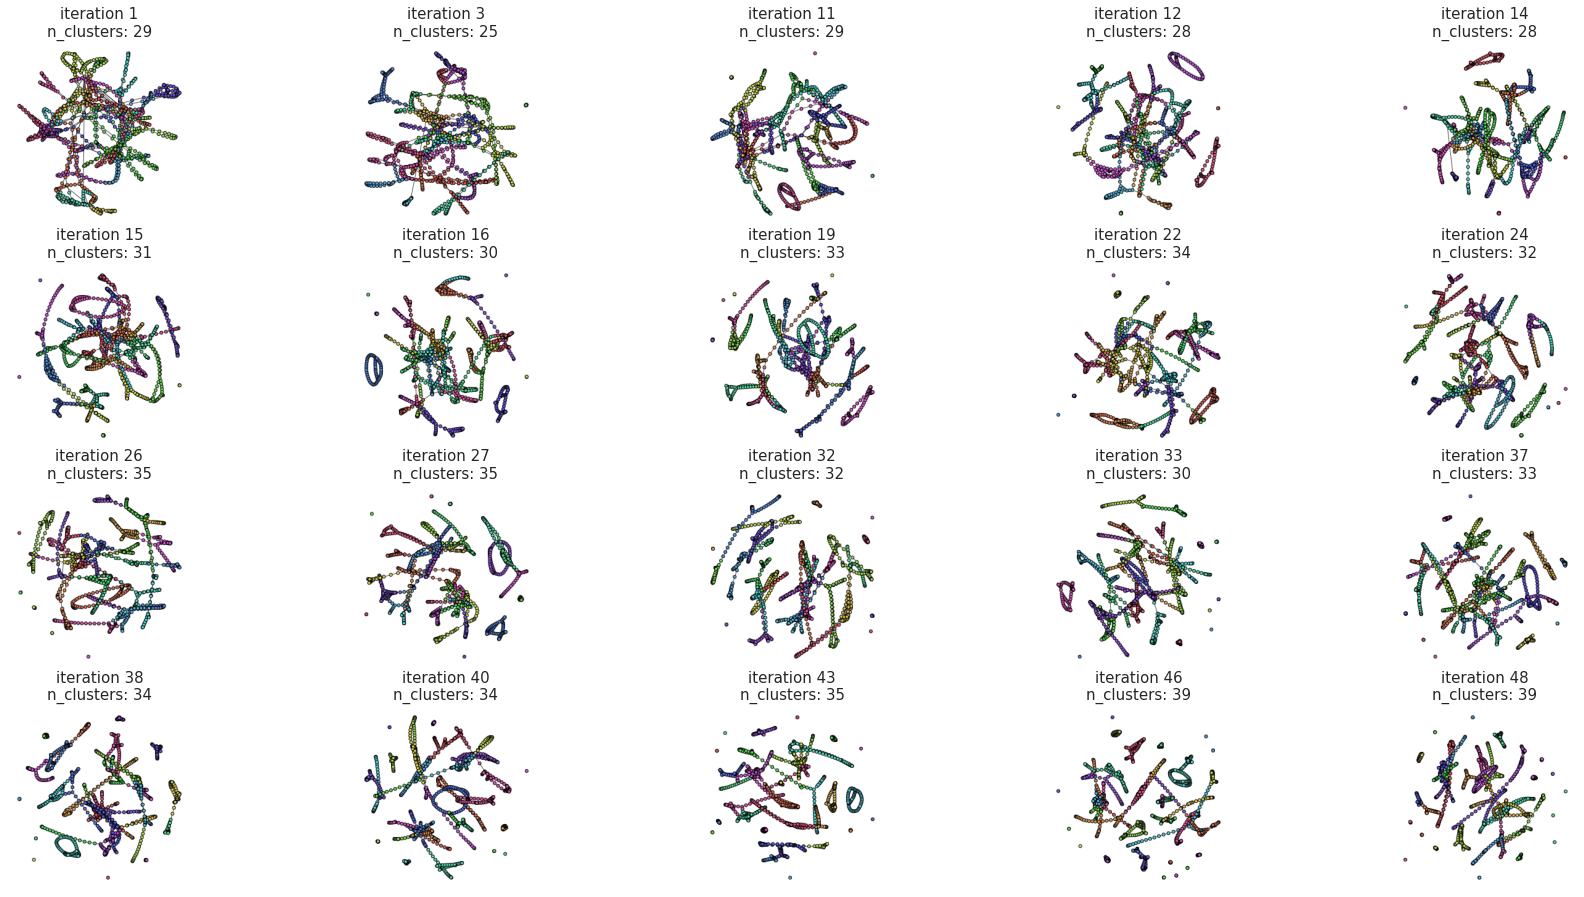

In [104]:
plt.figure(figsize=(30, 40))
plot_graphs(sample=True)

Clusters become more and more separated across iterations as expected. we should check whether we get to a condition in which we have pretty well separated clusters consisting of multiple nodes (i.e. not only one node clusters)

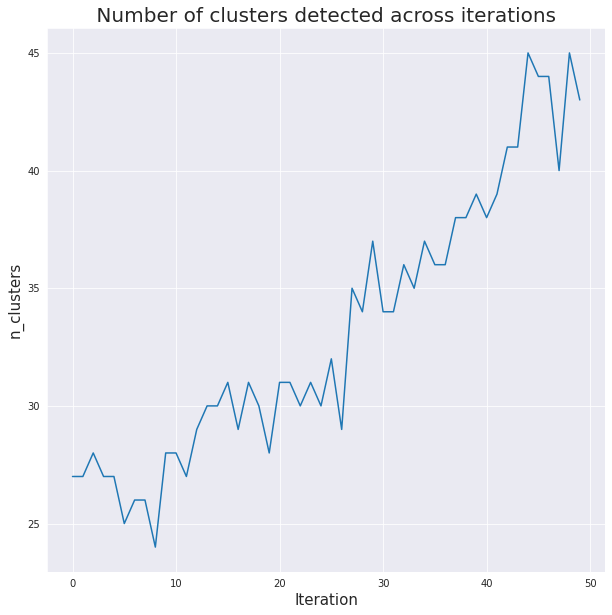

In [82]:
plt.figure(figsize=(10,10))
s = sns.lineplot(x='iteration', y='n_clusters', data=metrics)
s.set_xlabel("Iteration",fontsize=15)
s.set_ylabel("n_clusters",fontsize=15)
plt.title(" Number of clusters detected across iterations ", fontsize=20);

In [107]:
# need to extract weights for computing the shortest paths
z.es.attribute_names()

['id']

3) Approach of most central node selection taken from excercise session 3

In [ ]:
z_undirected = z.copy()
z_undirected.to_undirected()
lvn = z_undirected.community_multilevel()
lvn.modularity
communities = lvn.subgraphs()

def getCentralSubStops(subgraph):
  wdeg = subgraph.strength()
  betw = subgraph.betweenness()
  ## Select nodes which belong to the top 5% most central nodes based on both weighted degree and betweenness
  centrals = subgraph.vs[np.where((wdeg>=np.percentile(wdeg,95))& (betw>=np.percentile(betw, 95)))[0].tolist()]['id']
  return centrals
centrals = getCentralSubStops(communities[0])